In [5]:
file1 = "../remote/Silicon_etch.obj"
# file1 = "../remote/Nitride_etch.obj"
file2 = "../test/initial_struct_600_600.obj"

Slice 0: similarity = 19.0000
Slice 1: similarity = 41.0000
Slice 2: similarity = 47.0000
Slice 3: similarity = 48.0000
Slice 4: similarity = 38.0000
Slice 5: similarity = 40.0000
Slice 6: similarity = 34.0000
Slice 7: similarity = 47.0000
Slice 8: similarity = 46.0000
Slice 9: similarity = 37.0000
Slice 10: similarity = 46.0000
Slice 11: similarity = 36.0000
Slice 12: similarity = 39.0000
Slice 13: similarity = 39.0000
Slice 14: similarity = 35.0000
Slice 15: similarity = 29.0000
Slice 16: similarity = 30.0000
Slice 17: similarity = 23.0000
Slice 18: similarity = 13.0000
Slice 19: similarity = 64.0000
Overall similarity: 37.5500


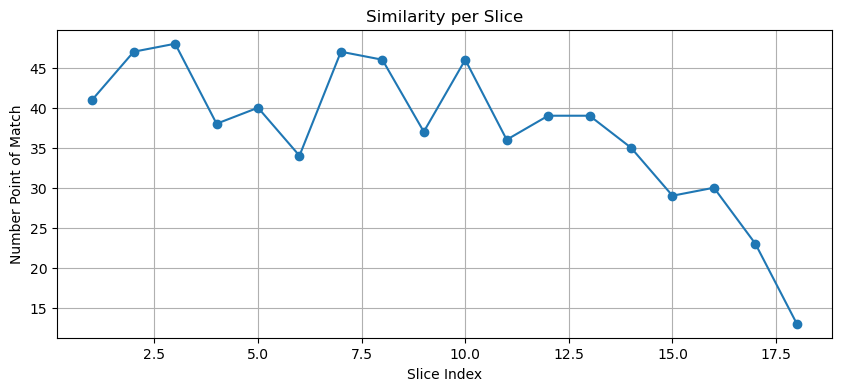

In [6]:
import numpy as np
import cv2
from pathlib import Path
import trimesh
import matplotlib.pyplot as plt

class ObjSimilaritySlicer:
    def __init__(self, obj_path1, obj_path2, num_slices=20, image_size=(512, 512)):
        self.mesh1 = self.load_obj(obj_path1)
        self.mesh2 = self.load_obj(obj_path2)
        self.num_slices = num_slices
        self.image_size = image_size
        self.slices1 = self.slice_obj(self.mesh1)
        self.slices2 = self.slice_obj(self.mesh2)

    def load_obj(self, path):
        return trimesh.load_mesh(path, file_type='obj')

    def slice_obj(self, mesh):
        vertices = mesh.vertices
        min_y, max_y = vertices[:, 1].min(), vertices[:, 1].max()
        slice_thickness = (max_y - min_y) / self.num_slices

        slices = []
        for i in range(self.num_slices):
            y_min = min_y + i * slice_thickness
            y_max = y_min + slice_thickness
            slice_vertices = vertices[(vertices[:, 1] >= y_min) & (vertices[:, 1] < y_max)]

            image = self.create_y_slice_image(slice_vertices)
            slices.append(image)

        return slices

    def create_y_slice_image(self, slice_vertices):
        if slice_vertices.shape[0] < 10:
            return np.zeros(self.image_size, dtype=np.uint8)

        x = slice_vertices[:, 0]
        z = slice_vertices[:, 2]

        # Normalize to fit into image
        x_norm = (x - x.min()) / (x.max() - x.min() + 1e-8)
        z_norm = (z - z.min()) / (z.max() - z.min() + 1e-8)
        x_img = (x_norm * (self.image_size[1] - 1)).astype(np.int32)
        z_img = (z_norm * (self.image_size[0] - 1)).astype(np.int32)

        image = np.zeros(self.image_size, dtype=np.uint8)
        image[z_img, x_img] = 255

        # Apply dilation and blur to make SIFT work better
        image = cv2.dilate(image, np.ones((3, 3), np.uint8), iterations=1)
        image = cv2.GaussianBlur(image, (5, 5), 2)
        return image

    def compute_sift_features(self, image):
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(image, None)
        return keypoints, descriptors

    def match_features_flann(self, desc1, desc2):
        index_params = dict(algorithm=0, trees=5)
        search_params = dict(checks=100)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        try:
            matches = flann.knnMatch(desc1, desc2, k=2)
        except cv2.error:
            return []

        # Apply Lowe's ratio test
        good_matches = []
        for m_n in matches:
            if len(m_n) < 2:
                continue
            m, n = m_n
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)
        return good_matches

    def compute_slice_similarity(self, img1, img2):
        kp1, desc1 = self.compute_sift_features(img1)
        kp2, desc2 = self.compute_sift_features(img2)

        if desc1 is None or desc2 is None or len(desc1) < 2 or len(desc2) < 2:
            return 0.0

        matches = self.match_features_flann(desc1, desc2)
        intersection = len(matches)
        union = 1

        return intersection / union if union > 0 else 0.0


    def compute_overall_similarity(self):
        similarities = []
        for i in range(self.num_slices):
            sim = self.compute_slice_similarity(self.slices1[i], self.slices2[i])
            print(f"Slice {i}: similarity = {sim:.4f}")
            similarities.append(sim)
        return np.mean(similarities)

    def draw_matches_for_slice(self, slice_idx, save_path=None, show=False):
        img1 = self.slices1[slice_idx]
        img2 = self.slices2[slice_idx]
        kp1, desc1 = self.compute_sift_features(img1)
        kp2, desc2 = self.compute_sift_features(img2)

        if desc1 is None or desc2 is None or len(desc1) < 2 or len(desc2) < 2:
            print(f"Slice {slice_idx}: Not enough features for matching.")
            return None

        matches = self.match_features_flann(desc1, desc2)
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        if save_path:
            img_matches = cv2.rotate(img_matches, cv2.ROTATE_180, img_matches)
            cv2.imwrite(str(save_path), img_matches)
        if show:
            cv2.imshow(f"Slice {slice_idx} Matches", img_matches)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        return img_matches

    def plot_similarity_heatmap(self):
        similarities = []
        for i in range(1, self.num_slices-1):
            sim = self.compute_slice_similarity(self.slices1[i], self.slices2[i])
            similarities.append(sim)

        plt.figure(figsize=(10, 4))
        plt.plot(range(1, self.num_slices-1), similarities, marker='o')
        plt.title("Similarity per Slice")
        plt.xlabel("Slice Index")
        plt.ylabel("Number Point of Match")
        plt.grid(True)
        plt.show()


slicer = ObjSimilaritySlicer(file1, file2, num_slices=20)
similarity = slicer.compute_overall_similarity()
print(f"Overall similarity: {similarity:.4f}")
slicer.plot_similarity_heatmap()
for i in range(slicer.num_slices):
    slicer.draw_matches_for_slice(i, save_path=f"matches_slice_{i}.png")